In [1]:
import os
import json
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
BASE_DIR = "data"


In [3]:
def process_json_files(base_dir="data"):
    submissoes = []

    if not os.path.exists(base_dir):
        print(f"Diretório {base_dir} não encontrado.")
        return pd.DataFrame()

    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".json"):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, "r", encoding="utf-8") as f:
                        content = json.load(f)

                    submission = content.get("data", {}).get("submissionDetails", {})

                    if not submission or not submission.get("code"):
                        print(f"JSON ignorado: {file_path} - Dados insuficientes ou código ausente.")
                        continue
                    
                    path_parts = root.split(os.sep)
                    difficulty = path_parts[2]  
                    model = path_parts[4]
                    problem_slug = submission.get("question", {}).get("titleSlug", "")
                    language = submission.get("lang", {}).get("name", "")
                    status_code = submission.get("statusCode", None)
                    total_correct = submission.get("totalCorrect", 0)
                    total_tests = submission.get("totalTestcases", 0)
                    runtime = submission.get("runtime", None)
                    memory = submission.get("memory", None)
                    timestamp = submission.get("timestamp", None)
                    code = submission.get("code", "")

                    submissoes.append({
                        "model": model,
                        "difficulty": difficulty,
                        "problem": problem_slug,
                        "language": language,
                        "status_code": status_code,
                        "total_correct": total_correct,
                        "total_tests": total_tests,
                        "runtime": runtime,
                        "memory": memory,
                        "timestamp": datetime.fromtimestamp(timestamp) if timestamp else None,
                        "code": code,
                        "source_file": file_path
                    })

                except Exception as e:
                    print(f"Erro ao processar {file_path}: {e}")

    return pd.DataFrame(submissoes)


In [4]:
df = process_json_files()
print(f"Total de submissões processadas: {len(df)}")
df.head()


JSON ignorado: data\marcelo_problems\hard\25_reverse-nodes-in-k-group\claude\25_reverse-nodes-in-k-group_C.json - Dados insuficientes ou código ausente.
JSON ignorado: data\marcelo_problems\hard\25_reverse-nodes-in-k-group\claude\25_reverse-nodes-in-k-group_Py.json - Dados insuficientes ou código ausente.
JSON ignorado: data\marcelo_problems\hard\25_reverse-nodes-in-k-group\deepseek\25_reverse-nodes-in-k-group_C.json - Dados insuficientes ou código ausente.
JSON ignorado: data\marcelo_problems\hard\25_reverse-nodes-in-k-group\deepseek\25_reverse-nodes-in-k-group_Py.json - Dados insuficientes ou código ausente.
JSON ignorado: data\marcelo_problems\hard\25_reverse-nodes-in-k-group\gpt\25_reverse-nodes-in-k-group_C.json - Dados insuficientes ou código ausente.
JSON ignorado: data\marcelo_problems\hard\25_reverse-nodes-in-k-group\gpt\25_reverse-nodes-in-k-group_Py.json - Dados insuficientes ou código ausente.
JSON ignorado: data\marcelo_problems\hard\30_substring-with-concatenation-of-all-

,model,difficulty,problem,language,status_code,total_correct,total_tests,runtime,memory,timestamp,code,source_file
0,claude,easy,best-time-to-buy-and-sell-stock,c,10,212.0,212,0,15220000,2025-06-01 22:20:50,#include <stdio.h>\n#include <stdlib.h>\n\n// ...,data\henrique_problems\easy\121_best-time-to-b...
1,claude,easy,best-time-to-buy-and-sell-stock,python3,10,212.0,212,80,19284000,2025-06-01 22:23:55,class Solution(object):\n def maxProfit(sel...,data\henrique_problems\easy\121_best-time-to-b...
2,deepseek,easy,best-time-to-buy-and-sell-stock,c,10,212.0,212,0,15312000,2025-06-01 22:21:22,#include <stdio.h>\n#include <limits.h>\n\nint...,data\henrique_problems\easy\121_best-time-to-b...
3,deepseek,easy,best-time-to-buy-and-sell-stock,python3,10,212.0,212,24,18992000,2025-06-01 22:24:39,class Solution(object):\n def maxProfit(sel...,data\henrique_problems\easy\121_best-time-to-b...
4,gpt,easy,best-time-to-buy-and-sell-stock,c,10,212.0,212,0,15372000,2025-06-01 22:19:44,#include <stdio.h>\n\nint maxProfit(int* price...,data\henrique_problems\easy\121_best-time-to-b...


In [5]:

df['full_acceptance'] = df['total_correct'] == df['total_tests']
df['partial_acceptance'] = df['total_correct'] >= (df['total_tests'] * 0.5)
df['rejected'] = df['total_correct'] < (df['total_tests'] * 0.5)

    model difficulty language  total_submissions  full_accept_rate  \
0  claude       easy        c                 15          0.800000   
1  claude       easy  python3                 15          0.866667   
2  claude       hard        c                 10          1.000000   
3  claude       hard  python3                 10          1.000000   
4  claude     medium        c                 15          0.933333   

   partial_accept_rate  avg_runtime_ms  avg_memory_bytes  
0             0.866667      158.400000      9.785867e+06  
1             0.933333       15.666667      1.816160e+07  
2             1.000000       11.600000      2.060600e+07  
3             1.000000       93.000000      2.265920e+07  
4             0.933333       77.533333      2.557200e+07  


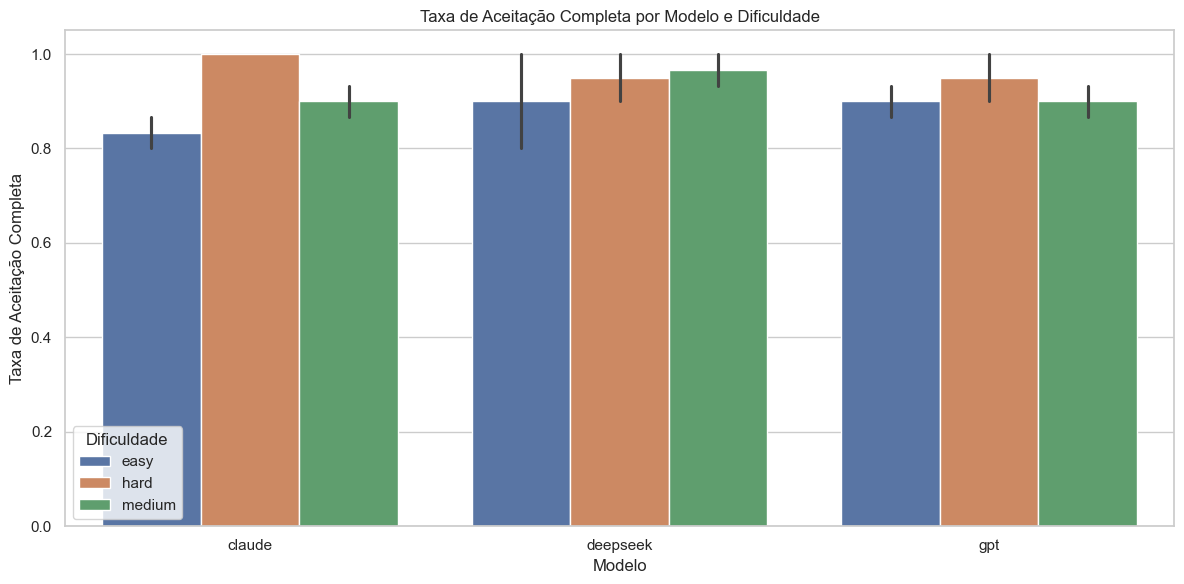

In [9]:
summary = df.groupby(['model', 'difficulty', 'language']).agg(
    total_submissions=('full_acceptance', 'count'),
    full_accept_rate=('full_acceptance', 'mean'),
    partial_accept_rate=('partial_acceptance', 'mean'),
    avg_runtime_ms=('runtime', 'mean'),
    avg_memory_bytes=('memory', 'mean')
).reset_index()

print(summary.head())

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=summary, x='model', y='full_accept_rate', hue='difficulty')
plt.title('Taxa de Aceitação Completa por Modelo e Dificuldade')
plt.xlabel('Modelo')
plt.ylabel('Taxa de Aceitação Completa')
plt.xticks()
plt.legend(title='Dificuldade')
plt.tight_layout()
plt.show()

In [ ]:
qualitative_samples = df[df['full_acceptance']].groupby(['model', 'difficulty']).apply(
    lambda x: x.nsmallest(3, 'runtime')
).reset_index(drop=True)

qualitative_samples[['model', 'difficulty', 'language', 'code', 'problem']].to_csv('qualitative_samples.csv', index=False)




C:\Users\henri\AppData\Local\Temp\ipykernel_13208\3425176325.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  qualitative_samples = df[df['full_acceptance']].groupby(['model', 'difficulty']).apply(
